In [1]:
import os
os.chdir("/Users/karol/Desktop/Antwerp/ai_project")
import torch
import torch
import torch.nn as nn
from model import MLP1, MLP2, TwoTower, TwoTowerEmbedded, LogisticRegression, TwoTowerFinal
from data_reader import load_data, data_preprocessing, load_data_mf, load_customers_articles, customer_buckets, matrix_representation, create_random_candidates, articles_embbedings
from helper import train_softmax, train_two_tower, train_two_tower_embedded, train_logistic
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from recommenders import recommender_softmax, recommender_two_towers, recommender_two_towers_embedded, recommender_logistic, recommender_two_towers_final
import matplotlib.pyplot as plt
import pickle

# Data Preprocessing

### Assumptions
- Most important outcomes from feature engineering part were applied in data preprocessing function.
- Function split_transaction generates targets (last purchases are considered as targets).
- Function matrix representation transform transaction to pivot matrix.
- Create specific Dataset classes for specific task.
- Use sparse matrices to handle sparse data (create collate_fn for DataLoaders).

### Preprocess and save data

In [17]:
# transactions, articles, customers, article_encodings, customer_encodings, article_decodings, customer_decodings = data_preprocessing(feature_generation=False, return_encodings=True, save=True)

### Load preprocessed data and apply one hot encoding for articles and customers

In [2]:
# read data
transactions = pd.read_csv("data/preprocessed/transactions.csv") 
articles = pd.read_csv("data/preprocessed/articles.csv") 
customers = pd.read_csv("data/preprocessed/customers.csv") 

# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

article_enc = OneHotEncoder(sparse_output=True)
articles = article_enc.fit_transform(articles)

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency"]
customers_cont = ["age"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

# Softmax DNN

### Assumptions
- The input is the purchase history without last purchase,
- The target is the basket of the last purchase,
- We are interested in whether article was bought not its amount. Therefore, the binary values are allowed.
- In the target basket multiple articles could be bought therefore the sigmoid activation function was used at the last layer. It assumes that decision to buy specific article is independent from other products that customer is buying.
- As I have multi-classification problem and I use sigmoid asa final activation layer I decided to use BCEWithLogitsLoss which supposed to deal with this configuration.


### Load Data & Create Model

In [3]:
train_dataloader_MLP, val_dataloader_MLP = load_data(transactions, train_test=True, batch_size=1000)

### Create & Train basic Model 

In [3]:
# create model
model = MLP1(input_dim=articles.shape[0], output_dim=articles.shape[0])
# get params
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/MLP2.pt"
# train
# val_loss_MLP = train_softmax(model, train_dataloader_MLP, val_dataloader_MLP, criterion, optimizer, save_dir, num_epochs=10)

NameError: name 'train_dataloader_MLP' is not defined

### Load trained model

In [3]:
MLP1 = torch.load("AI_project/RQ1/models/MLP1.pt")

### Generate recommendations for test data

In [7]:
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
recommendations, recall, precision = recommender_softmax(MLP1, val_dataloader_MLP, articles_recently_sold, evaluate=True, top_k=10)
print(f"Precision: {precision}\nRecall: {recall}")

100%|██████████| 138/138 [01:26<00:00,  1.60it/s]

Precision: 3.717255353576583e-05
Recall: 0.00012372095079626888


### Ideas for improvements:
- No warm start
- Model should be trained on customers who had at least two purchases
- We take into account baskets which are based on the past 2 years. Maybe we should train model based on customers who bought articles in last month.
- Different way to measure accuracy.
- Customers whou didn't developed any patterns (bought low amount of clothes) should be recommended with current top selling articles.
- Develop more complex (deeper) model.
- More training.
- Distinguish customers who buys specific articles multiple times.
### Potential Issues:
- We need to predict articles for customers who were used to train the model.

**Idea**: recommend things that haven't been bought.



# Matrix Factorization with DNN

### Assumptions
- Firstly, it was decided to use one hot encoding for all categorical features.
- Two tower architecture was used which is compsed from two different classes, which are responsible for encoding customer and article features. 
- These models are used for estimating embeddings for recommendations.
- To estimate the probability of buying article x by customer y the product between corresponding embbedings is calculated and then the sigmoid function is applied. 
- For training purposes the random negative candidates have been generated.
- Weights for recent articles

### Load data

In [7]:
# transactions_negatives = create_random_candidates(transactions, save_dir=None, num_sample=30_000_000)
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)

### Train Model

In [ ]:
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTower(input_article_dim, input_customer_dim, output_dim=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTower1.pt"
# val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 55595/55595 [12:57<00:00, 71.47it/s]


Epoch [1/10] - Train Loss: 0.1969, Validation Loss: 0.1761%


100%|██████████| 55595/55595 [12:57<00:00, 71.47it/s]


Epoch [2/10] - Train Loss: 0.1975, Validation Loss: 0.1760%


100%|██████████| 55595/55595 [12:58<00:00, 71.44it/s]


Epoch [3/10] - Train Loss: 0.1971, Validation Loss: 0.1760%


100%|██████████| 55595/55595 [12:57<00:00, 71.48it/s]


Epoch [4/10] - Train Loss: 0.1970, Validation Loss: 0.1760%


100%|██████████| 55595/55595 [12:58<00:00, 71.42it/s]


Epoch [5/10] - Train Loss: 0.1969, Validation Loss: 0.1760%


100%|██████████| 55595/55595 [12:58<00:00, 71.45it/s]


Epoch [6/10] - Train Loss: 0.1971, Validation Loss: 0.1759%


100%|██████████| 55595/55595 [12:58<00:00, 71.44it/s]


Epoch [7/10] - Train Loss: 0.1975, Validation Loss: 0.1759%


100%|██████████| 55595/55595 [12:57<00:00, 71.48it/s]


Epoch [8/10] - Train Loss: 0.1976, Validation Loss: 0.1759%


100%|██████████| 55595/55595 [12:58<00:00, 71.43it/s]


Epoch [9/10] - Train Loss: 0.1977, Validation Loss: 0.1759%


100%|██████████| 55595/55595 [12:58<00:00, 71.44it/s]


Epoch [10/10] - Train Loss: 0.1978, Validation Loss: 0.1759%


### Load Model

In [6]:
TwoTower1 = torch.load("AI_project/RQ1/models/TwoTower1.pt")

### Load data required for recommendations

In [7]:
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)

### Evaluate Recommendations

In [8]:
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
recommendations, recall, precision = recommender_two_towers(TwoTower1, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:09<00:00, 150.66it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 247.05it/s]


Get recommendations...


100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


Precision: 0.005470567940746831
Recall: 0.001559738616899209


### Ideas for improvements:
- Use embeddings for warm start
- Develop ebedding layers.
- Generate more features.
- More training.
- Distinguish customers who buys specific articles multiple times.
- Use article embeddings for recommendations.
- Mix ways of recommending things

# Evaluation

In [10]:
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]

recall_MLP_list = []
precision_MPL_list = []

recall_TwoTower_list = []
precision_TwoTower_list = []

for k in np.arange(5,30,5):
    _, recall_MLP, precisionMLP = recommender_softmax(MLP1, val_dataloader_MLP, articles_recently_sold, evaluate=True, top_k=k)
    _, recall_TT, precision_TT = recommender_two_towers(TwoTower1, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=k)
    
    recall_MLP_list.append(recall_MLP)
    recall_TwoTower_list.append(recall_TT)
    precision_MPL_list.append(precisionMLP)
    precision_TwoTower_list.append(precision_TT)



100%|██████████| 138/138 [01:01<00:00,  2.26it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:10<00:00, 127.13it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 246.41it/s]


Get recommendations...


100%|██████████| 138/138 [01:03<00:00,  2.17it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 223.68it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 221.47it/s]


Get recommendations...


100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 237.55it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 246.19it/s]


Get recommendations...


  0%|          | 0/138 [00:00<?, ?it/s]/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/recommenders.py:28: UserWarning: torch.topk support for k>16 by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Shape.mm:71.)
  _, top_k_indices = torch.topk(results, k=top_k, dim=1)
100%|██████████| 138/138 [01:07<00:00,  2.04it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 232.02it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 226.18it/s]


Get recommendations...


100%|██████████| 138/138 [01:16<00:00,  1.80it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 219.30it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 227.71it/s]


Get recommendations...


100%|██████████| 137/137 [00:36<00:00,  3.75it/s]


### Random Recommendations

In [45]:
recall_random_list = []
precision_random_list = []

def random_rec_eval(test_customers, articles, targets, top_k):
    # Define the matrix dimensions
    rows, cols = len(test_customers), articles.shape[0]
    num_ones_per_row = top_k

    # Generate random positions for ones in each row
    random_positions = np.random.choice(cols, (rows, num_ones_per_row))
    # Create arrays for data, row indices, and column indices
    data = np.ones(num_ones_per_row * rows)
    row_indices = np.repeat(np.arange(rows), num_ones_per_row)
    col_indices = random_positions.flatten()

    # Create the sparse matrix using the collected data, row indices, and column indices
    random_rec = csr_matrix((data, (row_indices, col_indices)), shape=(rows, cols))
    correct_recommendations = random_rec.multiply(targets)
    total_correct = correct_recommendations.sum().item()
    total  = targets.sum().item()
    recall = total_correct / total
    precision = total_correct / (top_k*random_rec.shape[0])
    return recall, precision

for k in np.arange(5,30,5):
    recall, precision = random_rec_eval(test_customers, articles, targets, top_k=k)
    recall_random_list.append(recall)
    precision_random_list.append(precision)

In [42]:
# recall_MLP_list = [recall.to("cpu").item() for recall in recall_MLP_list]
# precision_MPL_list = [precision.to("cpu").item() for precision in precision_MPL_list]

### Recall plot

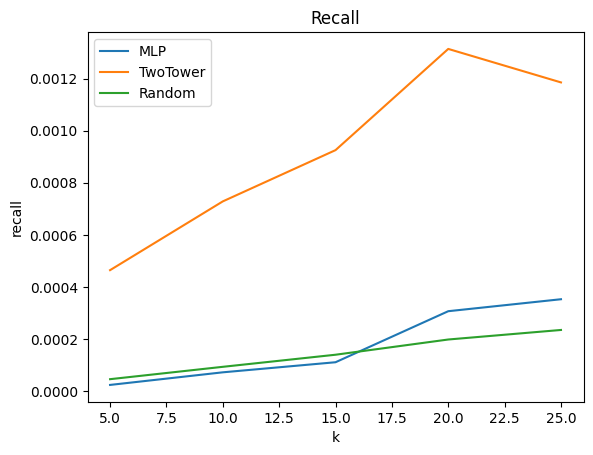

In [46]:
plt.plot(np.arange(5,30,5),recall_MLP_list, label="MLP")
plt.plot(np.arange(5,30,5),recall_TwoTower_list, label="TwoTower")
plt.plot(np.arange(5,30,5),recall_random_list, label="Random")
plt.title("Recall")
plt.legend()
plt.xlabel("k")
plt.ylabel("recall")
plt.show()

### Precision plot

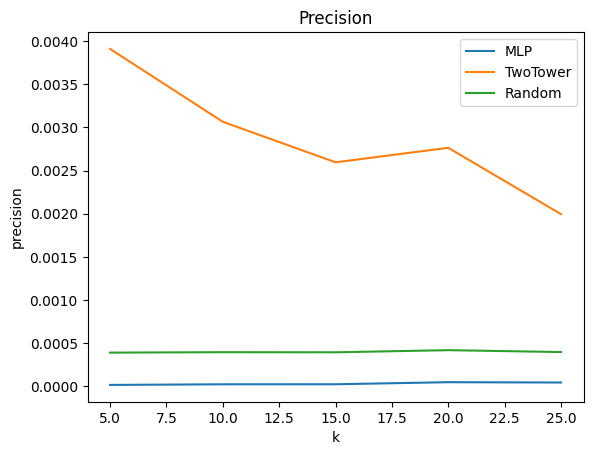

In [47]:
plt.plot(np.arange(5,30,5),precision_MPL_list,  label="MLP")
plt.plot(np.arange(5,30,5), precision_TwoTower_list,  label="TwoTower")
plt.plot(np.arange(5,30,5),precision_random_list, label="Random")
plt.title("Precision")
plt.legend()
plt.xlabel("k")
plt.ylabel("precision")
plt.show()

# Get Final Recommendations

### MLP

In [50]:
transactions = pd.read_csv("data/preprocessed/transactions.csv") 
dataloader = load_data(transactions, train_test=False, batch_size=1000)
MLP1 = torch.load("AI_project/RQ1/models/MLP1.pt")
recommendations = recommender_softmax(MLP1, dataloader, articles_recently_sold, evaluate=False, top_k=12).to(torch.int64).to("cpu").numpy()
output = pd.DataFrame(recommendations).reset_index()

100%|██████████| 1372/1372 [05:06<00:00,  4.48it/s]


In [51]:
with open('data/preprocessed/customers_decoding.pickle', 'rb') as file:
    customer_dict = pickle.load(file)

with open('data/preprocessed/articles_decoding.pickle', 'rb') as file:
    article_dict = pickle.load(file)

In [52]:
for i in np.arange(1,12,1):
    output[i] = output[i].apply(lambda x: article_dict["article_id"][x])
    
preds = [' '.join(['0' + str(article_dict["article_id"][p]) for p in ps]) for ps in recommendations]
submission = pd.DataFrame(zip(np.arange(len(preds)), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
submission.to_csv("submission/MLP/MLP2_submission.csv.gz", index=False)


### Two Tower

In [53]:
transactions = pd.read_csv("data/preprocessed/transactions.csv") 
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, batch_size=1000)
TwoTower = torch.load("AI_project/RQ1/models/TwoTower1.pt")
recommendations = recommender_two_towers(TwoTower, dataloader_cust, dataloader_art, targets=matrix_full, articles_recently_sold=articles_recently_sold, top_k=12).to(torch.int64).to("cpu").numpy()
output = pd.DataFrame(recommendations).reset_index()

Generate Customer Embeddings...


100%|██████████| 1372/1372 [01:06<00:00, 20.58it/s]


Generate Articles Embeddings...


100%|██████████| 106/106 [00:03<00:00, 29.15it/s]


Get recommendations...


100%|██████████| 1372/1372 [05:47<00:00,  3.95it/s]


In [54]:
for i in np.arange(1,12,1):
    output[i] = output[i].apply(lambda x: article_dict["article_id"][x])
    
preds = [' '.join(['0' + str(article_dict["article_id"][p]) for p in ps]) for ps in recommendations]
submission = pd.DataFrame(zip(np.arange(len(preds)), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
submission.to_csv("submission/TwoTower/TwoTower5_submission.csv.gz", index=False)

# Models Development


### 1. Deeper Architecture for the MLP1

In [4]:
# load data
train_dataloader_MLP, val_dataloader_MLP = load_data(transactions, train_test=True, batch_size=1000)
# create model
model = MLP2(input_dim=articles.shape[0], output_dim=articles.shape[0])
# get params
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
save_dir = "AI_project/RQ1/models/MLP2.pt"
# train
# val_loss_MLP = train_softmax(model, train_dataloader_MLP, val_dataloader_MLP, criterion, optimizer, save_dir, num_epochs=5)

In [7]:
# load model
MLP2 = torch.load("AI_project/RQ1/models/MLP2.pt")
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
# get recommendations
recommendations, recall, precision = recommender_softmax(MLP2, val_dataloader_MLP, articles_recently_sold, evaluate=True, top_k=10)
print(f"Precision: {precision}\nRecall: {recall}")

100%|██████████| 138/138 [02:17<00:00,  1.01it/s]

Precision: 0.00010058455662618988
Recall: 0.00033380018430761993


### 2. TwoTower model with embedding layers

In [5]:
# read article and customer data
articles = pd.read_csv("data/preprocessed/articles.csv") 
customers = pd.read_csv("data/preprocessed/customers.csv") 

# set indices
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency"]
customers_cont = ["age"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))
articles = csr_matrix(articles)

# load transaction
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
# dataloader
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)

In [5]:
article_cat_dim = articles_embbedings()
input_customer_dim = customers.shape[1]
model = TwoTowerEmbedded(article_cat_dim, input_customer_dim, output_dim=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerEmbedded.pt"
# val_loss_tower = train_two_tower_embedded(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

  0%|          | 0/55595 [00:00<?, ?it/s]/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/model.py:81: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  embedding_layer(x[:,i].T)
100%|██████████| 55595/55595 [12:45<00:00, 72.59it/s]


Epoch [1/10] - Train Loss: 0.2040, Validation Loss: 0.1806


100%|██████████| 55595/55595 [12:28<00:00, 74.26it/s]


Epoch [2/10] - Train Loss: 0.2045, Validation Loss: 0.1804


100%|██████████| 55595/55595 [12:27<00:00, 74.37it/s]


Epoch [3/10] - Train Loss: 0.2042, Validation Loss: 0.1803


100%|██████████| 55595/55595 [12:27<00:00, 74.37it/s]


Epoch [4/10] - Train Loss: 0.2046, Validation Loss: 0.1803


100%|██████████| 55595/55595 [12:27<00:00, 74.35it/s]


Epoch [5/10] - Train Loss: 0.2046, Validation Loss: 0.1803


100%|██████████| 55595/55595 [12:28<00:00, 74.29it/s]


Epoch [6/10] - Train Loss: 0.2047, Validation Loss: 0.1802


100%|██████████| 55595/55595 [12:27<00:00, 74.35it/s]


Epoch [7/10] - Train Loss: 0.2047, Validation Loss: 0.1802


100%|██████████| 55595/55595 [12:27<00:00, 74.34it/s]


Epoch [8/10] - Train Loss: 0.2049, Validation Loss: 0.1802


100%|██████████| 55595/55595 [12:28<00:00, 74.29it/s]


Epoch [9/10] - Train Loss: 0.2050, Validation Loss: 0.1802


100%|██████████| 55595/55595 [12:24<00:00, 74.67it/s]


Epoch [10/10] - Train Loss: 0.2050, Validation Loss: 0.1802


In [6]:
# load the model
TwoTowerEmb = torch.load("AI_project/RQ1/models/TwoTowerEmbedded.pt")
# generate targets
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# articles and customers dataloaders to push through corresponding towers
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# generate masks to recommend recent articles
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
# evaluate recommenders
recommendations, recall, precision = recommender_two_towers_embedded(TwoTowerEmb, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:04<00:00, 307.38it/s]


Generate Articles Embeddings...


  0%|          | 0/1056 [00:00<?, ?it/s]/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/model.py:81: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  embedding_layer(x[:,i].T)
100%|██████████| 1056/1056 [00:03<00:00, 299.07it/s]


Get recommendations...


100%|██████████| 137/137 [00:31<00:00,  4.30it/s]


Precision: 0.004529138436015826
Recall: 0.002709659144349369


### 3. Use Logistic Regression instead of Customer Tower

In [6]:
# load negatives
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)
# create model instance
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[0]
model = LogisticRegression(input_article_dim, input_customer_dim, output_dim=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/LogisticRegression.pt"
# train
# val_loss_tower = train_logistic(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=12)

#### Conclusion: Takes to much time let's focus on the recent transactions for training.

In [13]:
# transactions_reduced = transactions[transactions["t_dat"]>"2020-07-22"]
# save_dir = "data/preprocessed/transactions_negatives_reduced.csv"
# transactions_negatives_reduced = create_random_candidates(transactions_reduced, save_dir=save_dir, num_sample=len(transactions_reduced))

/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/data_reader.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions["purchased"] = np.ones(len(transactions))


In [4]:
# load negatives
transactions_negatives_reduced = pd.read_csv("data/preprocessed/transactions_negatives_reduced.csv")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives_reduced, batch_size=1000)
# create model instance
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[0]
model = LogisticRegression(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/LogisticRegression.pt"
# train
val_loss_tower = train_logistic(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=12)

In [7]:
input_customer_dim = customers.shape[0]
# load the model
LogReg = torch.load("AI_project/RQ1/models/LogisticRegression.pt")
# generate targets
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# articles and customers dataloaders to push through corresponding towers
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# generate masks to recommend recent articles
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
# evaluate recommenders
recommendations, recall, precision = recommender_logistic(LogReg, input_customer_dim, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

In [13]:
recommendations, recall, precision = recommender_logistic(LogReg, input_customer_dim, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)


Generate Articles Embeddings...


  0%|          | 0/1056 [00:00<?, ?it/s]

100%|██████████| 1056/1056 [00:03<00:00, 274.65it/s]


Get recommendations...


  0%|          | 1/1371980 [00:15<5887:05:29, 15.45s/it]

: 

#### Conclusion: Still too expensive to compute

### 4. Deeper TwoTower
- Deeper ArticleTower
- Increae the size of embeddings
- Play with the learning rate

In [8]:
# deep architecture
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerFinal.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 55595/55595 [13:22<00:00, 69.27it/s]


Epoch [1/10] - Train Loss: 0.1818, Validation Loss: 0.1665


100%|██████████| 55595/55595 [13:31<00:00, 68.49it/s]


Epoch [2/10] - Train Loss: 0.1820, Validation Loss: 0.1660


100%|██████████| 55595/55595 [13:36<00:00, 68.07it/s]


Epoch [3/10] - Train Loss: 0.1810, Validation Loss: 0.1658


100%|██████████| 55595/55595 [13:26<00:00, 68.95it/s]


Epoch [4/10] - Train Loss: 0.1821, Validation Loss: 0.1658


100%|██████████| 55595/55595 [13:23<00:00, 69.23it/s]


Epoch [5/10] - Train Loss: 0.1814, Validation Loss: 0.1657


100%|██████████| 55595/55595 [13:19<00:00, 69.51it/s]


Epoch [6/10] - Train Loss: 0.1811, Validation Loss: 0.1656


100%|██████████| 55595/55595 [14:05<00:00, 65.77it/s]


Epoch [7/10] - Train Loss: 0.1806, Validation Loss: 0.1656


100%|██████████| 55595/55595 [14:53<00:00, 62.20it/s]


Epoch [8/10] - Train Loss: 0.1819, Validation Loss: 0.1656


100%|██████████| 55595/55595 [14:13<00:00, 65.14it/s]


Epoch [9/10] - Train Loss: 0.1803, Validation Loss: 0.1655


100%|██████████| 55595/55595 [13:49<00:00, 67.04it/s]


Epoch [10/10] - Train Loss: 0.1812, Validation Loss: 0.1655


In [4]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerFinal.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:09<00:00, 143.60it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 214.37it/s]


Get recommendations...


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Precision: 0.005909167651527942
Recall: 0.00353529272479942


### 5. Train MLP on the recent baskets

In [7]:
# get recent transactions
transactions_recent = transactions[transactions.t_dat>"2020-07-22"]
# load data
train_dataloader_MLP, val_dataloader_MLP = load_data(transactions_recent, train_test=True, batch_size=1000)
# create model
model = MLP1(input_dim=articles.shape[0], output_dim=articles.shape[0])
# get params
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/MLP_recent.pt"
# train
val_loss_MLP = train_softmax(model, train_dataloader_MLP, val_dataloader_MLP, criterion, optimizer, save_dir, num_epochs=5)

 20%|██        | 1/5 [18:03<1:12:15, 1083.91s/it]

Epoch [1/5] - Train Loss: 0.6934, Validation Loss: 0.6934%


 40%|████      | 2/5 [36:40<55:09, 1103.19s/it]  

Epoch [2/5] - Train Loss: 0.6932, Validation Loss: 0.6932%


 60%|██████    | 3/5 [54:52<36:36, 1098.17s/it]

Epoch [3/5] - Train Loss: 0.6932, Validation Loss: 0.6932%


 80%|████████  | 4/5 [1:13:29<18:25, 1105.66s/it]

Epoch [4/5] - Train Loss: 0.6932, Validation Loss: 0.6932%


100%|██████████| 5/5 [1:31:51<00:00, 1102.37s/it]

Epoch [5/5] - Train Loss: 0.6932, Validation Loss: 0.6932%


In [5]:
# load model
MLP_recent = torch.load("AI_project/RQ1/models/MLP_recent.pt")
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
# get recommendations
recommendations, recall, precision = recommender_softmax(MLP_recent, val_dataloader_MLP, articles_recently_sold, evaluate=True, top_k=10)
print(f"Precision: {precision}\nRecall: {recall}")

100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Precision: 6.559862388664558e-05
Recall: 0.0002178401337005198


### Negative Sampling - top sold articles that haven't been bought

### Recommenders - candidates

In [55]:
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id").count()["t_dat"]
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()

canditates = [list(grouped_counts.sort_values(ascending=False)[0:1000].index)]

# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerFinal.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)

# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, canditates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 204.52it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 244.77it/s]


Get recommendations...


100%|██████████| 137/137 [00:35<00:00,  3.91it/s]


Precision: 0.007291032012273452
Recall: 0.0043620242222447494


In [57]:
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id").count()["t_dat"]
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()

canditates = [list(grouped_counts.sort_values(ascending=False)[0:5000].index)]

# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerFinal.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)

# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, canditates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 207.47it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 243.61it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


Precision: 0.007331405207408114
Recall: 0.004386178396140895


In [58]:
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id").count()["t_dat"]
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()

canditates = [list(grouped_counts.sort_values(ascending=False)[0:12].index)]

# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerFinal.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)

# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, canditates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 206.03it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 243.62it/s]


Get recommendations...


100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Precision: 0.004864358298649088
Recall: 0.0029102119821537253


In [66]:
with open('data/preprocessed/customers_decoding.pickle', 'rb') as file:
    customer_dict = pickle.load(file)

with open('data/preprocessed/articles_decoding.pickle', 'rb') as file:
    article_dict = pickle.load(file)

transactions = pd.read_csv("data/preprocessed/transactions.csv") 
# get candidates
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id").count()["t_dat"]
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()
canditates = [list(grouped_counts.sort_values(ascending=False)[0:5000].index)]
# load data
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, batch_size=1000)
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerFinal.pt")
recommendations = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, canditates, evaluate=False, top_k=12)
output = pd.DataFrame(recommendations).reset_index()

for i in np.arange(1,12,1):
    output[i] = output[i].apply(lambda x: article_dict["article_id"][x])
    
preds = [' '.join(['0' + str(article_dict["article_id"][p.item()]) for p in ps]) for ps in recommendations]
submission = pd.DataFrame(zip(np.arange(len(preds)), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
submission.to_csv("submission/TwoTower/TwoTowerFinal_submission.csv.gz", index=False)